## Wireless Access Point Placement for Optimal Coverage

Wireless networks are ubiquitous, appearing in homes, in businesses both small and large, and in an unnamable amount of other public and private spaces. They provide uncumbersome network access to users in situations where a wired network is not appropriate or feasible. This paper will use an abstraction where the network is reachable via a connection to one of possibly several mounted access points (APs) throughout a location. This abstraction suitably models several types of wireless networks, including 802.11 (wifi; see [3]). $$ $$
As most people today will know, the placement of a wireless AP will drastically effect the performance and effective coverage area given by the AP. In particular, clustering of APs around a fixed location provides for coverage that is highly inefficient, as coverage area is poorly utilized. Like all things which emit energy omnidirectionally, APs signal intesities drop off as you move away from the signal source (antenna), with a decrease in intesity occuring at a rate of roughly $1/d^2$, where $d$ is the distance from the AP. This is commonly referred to as the inverse-square law. This implies that, in a 2-dimensional approximation, an effective area for a given AP can be reliably modeled by a circle. $$$$ An in-depth analysis of the problem would investigate and take into account the behavior of the signal in the presence of interior walls and objects, whereas this paper does not for simplification purposes. In addition, this paper does not take into account some other factors which are important when determining the capacity of the amount of information that can be transfered in a given amount of time, commonly referred to as bandwidth. These things include channel assignment, amount of users associated to a given AP, distance from a user to their associated AP, particular signal strengths for certain pieces of hardware, etc. These considerations were omitted in order to simplify the problem as, in the presented form, the problem quickly becomes intractable. Much of the current research (see [1],[2]) mitigates this with the use of different heuristics, which is not in the scope of this project. In short, this is an exercise and not a serious research paper.

### Mathematical Model

The problem is cast into that of an ILP (integer linear program). The location of the future network is modeled as a fixed set of points, thus discretizing the problem space. The paper makes the simplifying assumption that the space is a square. As determining actual distance between points in two dimensions requires some non-linear math, an effective coverage area is approximated by counting a point in the range of an AP if you can walk from the AP in left/right and up/down movements to the point, where the total number of "movements" sum to the radius. This results in a square coverage area instead of a circle.  
The variables are as follows:  
**AP[i,j]:** a boolean variable, which is one if there exists an access point at location (i,j) and zero otherwise.  
**P[i,j}:** a boolean variable, which is one if location (i,j) is covered by an access point.  
**Allowed:** an integer variable which determines the allowed number of access points.  
**R:** an integer variable which determines the effective radius for the access point.  
**s:** an integer variable which determines the size of the problem space.  
**blocked:** a two-dimensional array holding points which are forbidden positions for placing access points.

$$max \sum_{i,j \in [s]} P_{i,j} $$  $$subject\space to\space AP_{i,j} = 0 \space \space \forall (i,j) \in blocked$$  
$$\sum_{i,j \in [s]} AP_{i,j} \leq Allowed$$  
$$P_{i,j} \leq \sum_{i,j \in [s]} AP_{i\pm a,j\pm b} \space \forall a\in[radius], \space b = radius - a \space\space\space \forall i,j \in [s]$$

The objective function maximizes the total number of covered access points. The first contraint prohibits access points from being placed into forbidden positions. The second constraint upper bounds the number of placed access points at the number allowed. The third constraint only allows a test point to be covered if there exists an access point which provides a coverage radius that the test point lies inside.

## Maximum Coverage Area

In [4]:
using JuMP, PyPlot, Cbc

In [5]:
m = Model(solver=CbcSolver())

s = 50
# Number of allowed access points
Allowed = 4
# effective radius of the chosen AP
R = 9
buf = s + 2*R

#allow the blocking of placement of APs into certian locations
num_blkd = 4
blocked = [ 1 1
            2 3
            7 2 
           11 25]

@variable(m, AP[1:buf,1:buf], Bin)
@variable(m, P[1:buf,1:buf], Bin)

@constraint(m, sum(AP[R + i,R + j] for i = 1:s, j = 1:s) <= Allowed)
    
    for i = 1:num_blkd
        @constraint(m, AP[R + blocked[i,1],R + blocked[i,2]] == 0)
    end
    
    # buffer space should not contribute coverage
    #not important as far as the model is concerned
@constraint(m, sum(AP[i,j] for i = 1:R,j = 1:buf) == 0)
@constraint(m, sum(AP[R + s + i,j] for i = 1:R,j = 1:buf) == 0)
@constraint(m, sum(AP[i,j] for i = 1:buf,j = 1:R) == 0)
@constraint(m, sum(AP[i,R + s + j] for i = 1:buf,j = 1:R) == 0)

for i = 1:s, j = 1:s
    x = R + i
    y = R + j
            
            #check for an AP within radius distance
    @constraint(m, P[x,y] <= sum(AP[x+a,y+b] for a = 0:R,b = 0:(R-a))
                           + sum(AP[x+a,y-b] for a = 0:R,b = 0:(R-a))
                           + sum(AP[x-a,y+b] for a = 0:R,b = 0:(R-a))
                           + sum(AP[x-a,y-b] for a = 0:R,b = 0:(R-a)))
end
@objective(m, Max, sum(P[R + i,R + j] for i = 1:s,j = 1:s));

In [6]:
solve(m)

:Optimal

## Results

Below we retrieve the resuls from the model and plot the results in an easily understood graphic. All test points are plotted with a color-coding, where blue dots are points that are covered by some access point. Green points are seen as uncovered by the model (here we clearly see that some points that are marked as uncovered would be covered had a more exact distance-finding method been known). Black points are locations that are forbidden to house an access point. The coverage area is drawn around each access point with a circle of specified radius. After the plot is a small text output which lists the percentage of points covered and how many access points were used. After some experimentation, we see that inputs of large problem spaces quickly become intractable. I've found that input sizes of around $50^2$ are solvable in minutes, where $s=50$ is the length of a side of the square problem space. Running time also depends on the number of allowed access points.

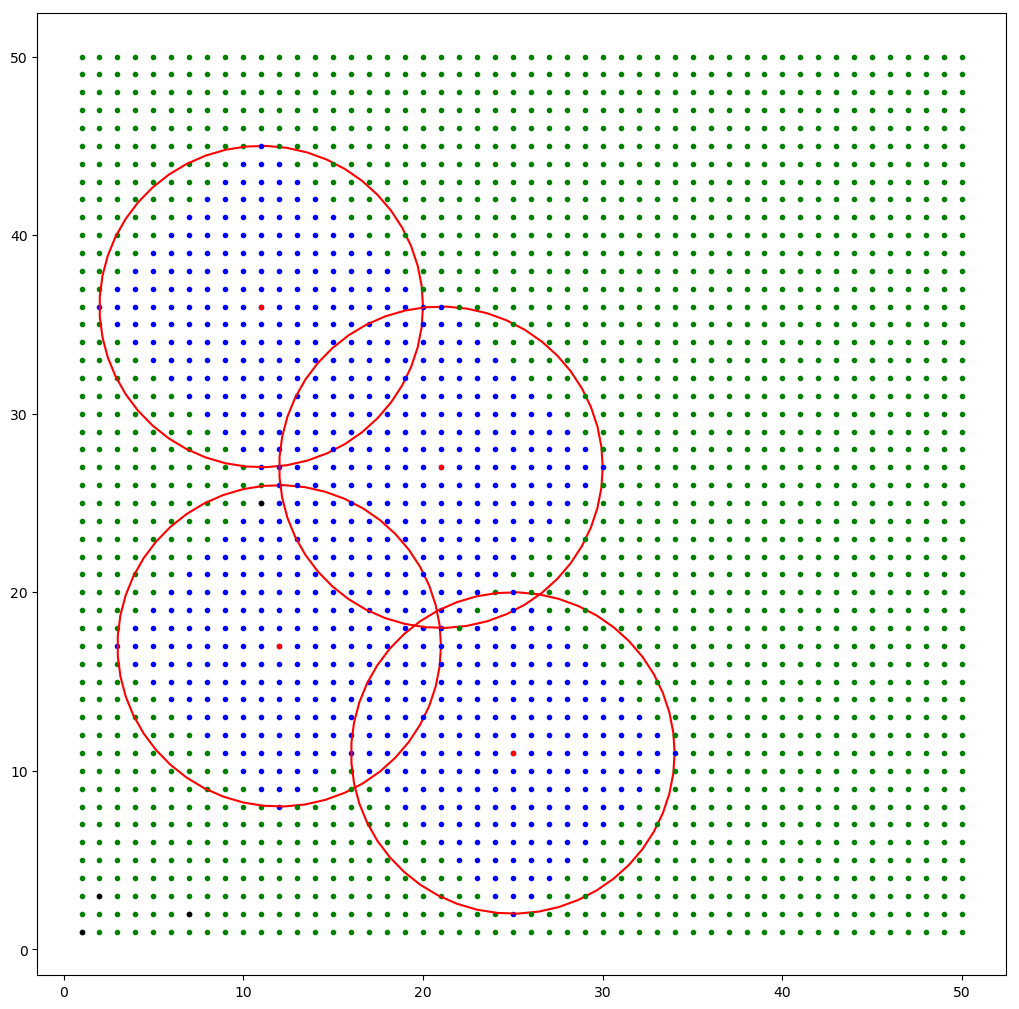

In [11]:
A = getvalue(P)
B = getvalue(AP)

X = linspace(0,2π,50)
#figsize may need to be adjusted depending on problem size
figure(figsize=(s/4,s/4))

for i = 1:s,j = 1:s
    if A[R + i,R + j] == 1
        plot(i,j,"b.")
    else
        plot(i,j,"g.")
    end
    if B[R + i,R + j] == 1
        plot(i,j,"r.")
        plot(i + R*cos(X), j + R*sin(X), "r-")
    end
end
for i = 1:num_blkd
    plot(blocked[i,1],blocked[i,2],"k.")
end

In [12]:
cover = getobjectivevalue(m)
ratio = cover / (s*s)

aps = 0
for i = 1:buf,j = 1:buf
    aps = aps + B[i,j]
end

@printf "Percentage of area covered: %4.2f%s\n" ratio*100 "%"
println("Number of access points used: ", aps)

Percentage of area covered: 28.96%
Number of access points used: 4.0


## Conclusion

The results were not unexecpted, with several access points spread out somewhat evenly throughout the space. Future possible research could encompass bandwidth optimization, utilizing all the things mentioned in the introduction. We could also attempt to find a better method for determining the membership of a test point for a given access point. One possible method would be to pre-calculate the distances between points before hand, thus eliminating the requirement to calculate the distances at runtime. One could also study the quality of the approximation used in this model, in particular lower and upper bounds of the error of the approximation. Perhaps another approach would use quadratic programming to minimize the amount of overlapping coverage area of placed access points, although how to do this is not quite so clear. A function to calculate overlapping area would need to be positive-definite, and I don't know if one exists.

### Citations

[1] "WLAN planning: Separate and joint optimization of both access point placement and channel assignment". Farsi, Achir, Boussetta. annals of telecommunications. pp. 263-274, 2015.  
[2] "A joint channel allocation and power control scheme...". Yang, Sun, Ji, Mao, Liu. Communication Technology (ICCT) 2013 15th IEEE International Conference. pp. 98-103, 2013.  
[3] http://standards.ieee.org/about/get/802/802.11.html (download required)